In [1]:
from stable_audio_tools.models.pretrained import get_pretrained_model
import torch

model, model_config = get_pretrained_model("stabilityai/stable-audio-open-small")


No module named 'flash_attn'
flash_attn not installed, disabling Flash Attention


/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [2]:
import sys
sys.path.append("/workspace/stable-audio-tools")


In [3]:
!pwd

/workspace


In [4]:
from pathlib import Path

AUDIO_DIR = Path("/workspace/data4")
OUTPUT_DIR = Path("/workspace/data4_preencoded_overlap")
SAMPLE_RATE = 44100
SEGMENT_DURATION = 8.0  # seconds
SEGMENT_SAMPLES = int(SAMPLE_RATE * SEGMENT_DURATION)
MIN_RMS_THRESHOLD = 0.01
OVERLAP_RATIO = 0.5
STEP_SIZE = int(SEGMENT_SAMPLES * (1 - OVERLAP_RATIO))

In [9]:
import torchaudio
import numpy as np
import torch
import json
from pathlib import Path

torch.set_float32_matmul_precision('high')

# === CONFIG ===
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# === MODEL CHECK ===
assert hasattr(model, "pretransform") and model.pretransform is not None, \
    "❌ Model must have a `.pretransform` encoder"

model.pretransform.to("cuda").eval()

def is_non_silent(segment, threshold=MIN_RMS_THRESHOLD):
    rms = segment.pow(2).mean().sqrt().item()
    return rms > threshold

print("🔁 Encoding and saving latent segments + metadata...")

total_saved = 0

for file in AUDIO_DIR.glob("*.wav"):
    try:
        audio, sr = torchaudio.load(file)
        if audio.numel() == 0:
            print(f"⚠️ Empty audio in {file.name}, skipping.")
            continue

        if sr != SAMPLE_RATE:
            audio = torchaudio.transforms.Resample(orig_freq=sr, new_freq=SAMPLE_RATE)(audio)

        if audio.shape[0] == 1:
            audio = audio.repeat(2, 1)  # [2, T]

        # Normalize
        peak = audio.abs().max()
        if peak > 0:
            audio = audio / peak

        audio_len = audio.shape[1]
        seg_idx = 0

        for start in range(0, audio_len - SEGMENT_SAMPLES + 1, STEP_SIZE):
            end = start + SEGMENT_SAMPLES
            segment = audio[:, start:end]

            if not is_non_silent(segment):
                continue

            segment = segment.unsqueeze(0).to("cuda")  # [1, 2, T]

            with torch.no_grad():
                latent = model.pretransform.encode(segment)  # [1, D, T']
                latent = latent.squeeze(0).cpu().numpy()     # [D, T']

            # === Save latent ===
            out_name = f"{file.stem}_ov{seg_idx:03d}"
            npy_path = OUTPUT_DIR / f"{out_name}.npy"
            np.save(npy_path, latent)

            # === Save metadata ===
            stem_lower = file.stem.lower()
            if "yb" in stem_lower:
                prompt = "NBA YoungBoy type aggressive trap beat"
            elif "baby" in stem_lower:
                prompt = "Lil Baby style melodic trap beat"
            else:
                prompt = "trap remix"

            padding_mask = [1] * latent.shape[-1]
            metadata = {
                "prompt": prompt,
                "seconds_total": SEGMENT_DURATION,
                "padding_mask": padding_mask
            }

            json_path = OUTPUT_DIR / f"{out_name}.json"
            with open(json_path, "w") as f:
                json.dump(metadata, f, indent=2)

            print(f"✅ Saved: {out_name}.npy + .json")
            seg_idx += 1
            total_saved += 1

    except Exception as e:
        print(f"❌ Error processing {file.name}: {e}")

print(f"🏁 Done. Saved {total_saved} valid latent segments + metadata to: {OUTPUT_DIR}")


🔁 Encoding and saving latent segments + metadata...
✅ Saved: baby2_ov000.npy + .json
✅ Saved: baby2_ov001.npy + .json
✅ Saved: baby2_ov002.npy + .json
✅ Saved: baby2_ov003.npy + .json
✅ Saved: baby2_ov004.npy + .json
✅ Saved: baby2_ov005.npy + .json
✅ Saved: baby2_ov006.npy + .json
✅ Saved: baby2_ov007.npy + .json
✅ Saved: baby2_ov008.npy + .json
✅ Saved: baby2_ov009.npy + .json
✅ Saved: baby2_ov010.npy + .json
✅ Saved: baby2_ov011.npy + .json
✅ Saved: baby2_ov012.npy + .json
✅ Saved: baby2_ov013.npy + .json
✅ Saved: baby2_ov014.npy + .json
✅ Saved: baby2_ov015.npy + .json
✅ Saved: baby2_ov016.npy + .json
✅ Saved: baby2_ov017.npy + .json
✅ Saved: yb3_ov000.npy + .json
✅ Saved: yb3_ov001.npy + .json
✅ Saved: yb3_ov002.npy + .json
✅ Saved: yb3_ov003.npy + .json
✅ Saved: yb3_ov004.npy + .json
✅ Saved: yb3_ov005.npy + .json
✅ Saved: yb3_ov006.npy + .json
✅ Saved: yb3_ov007.npy + .json
✅ Saved: yb3_ov008.npy + .json
✅ Saved: yb3_ov009.npy + .json
✅ Saved: yb3_ov010.npy + .json
✅ Saved: yb3_

In [5]:
from stable_audio_tools.data.dataset import create_dataloader_from_config
import json

with open("/workspace/dataset_config.json") as f:
    dataset_config = json.load(f)

train_loader = create_dataloader_from_config(
    dataset_config,
    batch_size=1,
    sample_size=SAMPLE_RATE * SEGMENT_DURATION,
    sample_rate=44100,
    audio_channels=2,
    num_workers=8
)


Found 218 files


In [6]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"


In [7]:
from stable_audio_tools.training.diffusion import DiffusionCondTrainingWrapper
import pytorch_lightning as pl
import torch

torch.set_float32_matmul_precision('high')

training_wrapper = DiffusionCondTrainingWrapper(
    model=model,
    lr=1e-4,
    pre_encoded=True
)

trainer = pl.Trainer(
    max_steps=2000,                     # <-- total steps to train
    accumulate_grad_batches=2,          # <-- simulate larger batch
    precision='16-mixed',                        # <-- mixed precision (faster)
    log_every_n_steps=600,               # <-- print loss every 10 steps
    enable_progress_bar=True,           
    enable_checkpointing=False,
    val_check_interval=None,
    strategy='auto',
    devices=1
)

trainer.fit(training_wrapper, train_dataloaders=train_loader)
training_wrapper.export_model("/workspace/stable-audio-tools/saved/final_model.pt")

with open("/workspace/stable-audio-tools/saved/final_model_config.json", "w") as f:
    json.dump(model_config, f, indent=2)



Using 16bit Automatic Mixed Precision (AMP)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/plugins/precision/amp.py:54: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                             | Params
-------------------------------------------------------------------
0 | diffusion     | ConditionedDiffusionModelWrapper | 497 M 
1 | diffusion_ema | EMA                              | 340 M 
2 | losses        | MultiLoss                        | 0     
-------------------------------------------------------------------


Training: |                                                                             | 0/? [00:00<?, ?it/s]

/workspace/stable-audio-tools/stable_audio_tools/models/conditioners.py:362: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.float16) and torch.set_grad_enabled(self.enable_grad):
`Trainer.fit` stopped: `max_steps=2000` reached.


In [2]:
#import torch
#import json
#from stable_audio_tools.models.diffusion import create_diffusion_cond_from_config

# Load saved config
#with open("/workspace/stable-audio-tools/saved/final_model_config.json") as f:
    #config = json.load(f)

# Rebuild model from config
#model = create_diffusion_cond_from_config(config)
#ckpt = torch.load("/workspace/stable-audio-tools/saved/final_model.pt", map_location="cuda")
#model.load_state_dict(ckpt["state_dict"])
#model.to("cuda").eval()


No module named 'flash_attn'
flash_attn not installed, disabling Flash Attention


/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


ConditionedDiffusionModelWrapper(
  (model): DiTWrapper(
    (model): DiffusionTransformer(
      (timestep_features): FourierFeatures()
      (to_timestep_embed): Sequential(
        (0): Linear(in_features=256, out_features=1024, bias=True)
        (1): SiLU()
        (2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (to_cond_embed): Sequential(
        (0): Linear(in_features=768, out_features=1024, bias=False)
        (1): SiLU()
        (2): Linear(in_features=1024, out_features=1024, bias=False)
      )
      (to_global_embed): Sequential(
        (0): Linear(in_features=768, out_features=1024, bias=False)
        (1): SiLU()
        (2): Linear(in_features=1024, out_features=1024, bias=False)
      )
      (transformer): ContinuousTransformer(
        (layers): ModuleList(
          (0-15): 16 x TransformerBlock(
            (pre_norm): LayerNorm()
            (self_attn): Attention(
              (to_qkv): Linear(in_features=1024, out_features=3072, bias

In [15]:
from stable_audio_tools.inference.generation import generate_diffusion_cond

conditioning = [{
    "prompt": "NBA Youngboy style trap",
    "seconds_total": 90.0
}]

negative_conditioning =[{
    'prompt': 'avoid repetition',
    'seconds_total': 90.0
}]

DURATION_SEC = sum(p["seconds_total"] for p in conditioning)  # = 90
SAMPLE_SIZE = int(SAMPLE_RATE * DURATION_SEC)  # = 3,969,000


output = generate_diffusion_cond(
    model=model.to("cuda"),       # make 100% sure model is on GPU
    steps=2048,
    cfg_scale=7.0,
    conditioning=conditioning,
    negative_conditioning=negative_conditioning,
    sample_size=SAMPLE_SIZE,       # 9 seconds
    device="cuda"                 # force everything onto GPU
)


2642284027


2048it [41:08,  1.21s/it]


In [16]:
import torchaudio
from einops import rearrange
import torch

# Rearrange: [B, C, T] -> [C, T] for saving
waveform = rearrange(output, "b c n -> c (b n)")

# Peak normalize and convert to 16-bit PCM
waveform = waveform.to(torch.float32).div(torch.max(torch.abs(waveform))).mul(32767).clamp(-32768, 32767).to(torch.int16).cpu()


In [17]:
torchaudio.save("remix_output_prompt_1024_steps.wav", waveform, sample_rate=44100)
print("✅ Saved to remix_output_prompt_1024_steps.wav")


✅ Saved to remix_output_prompt_1024_steps.wav


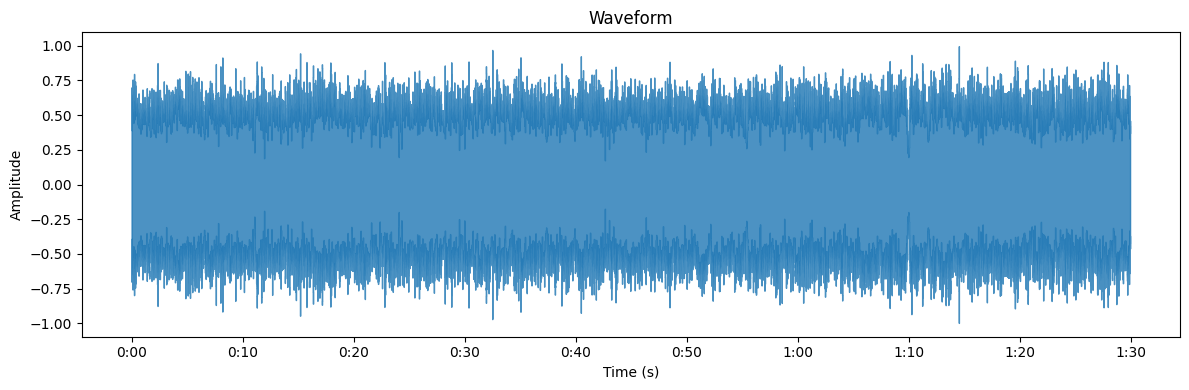

In [18]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load your audio file
audio_path = "remix_output_prompt_1024_steps.wav"
y, sr = librosa.load(audio_path, sr=44100)

# Plot waveform
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr, alpha=0.8)
plt.title("Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()


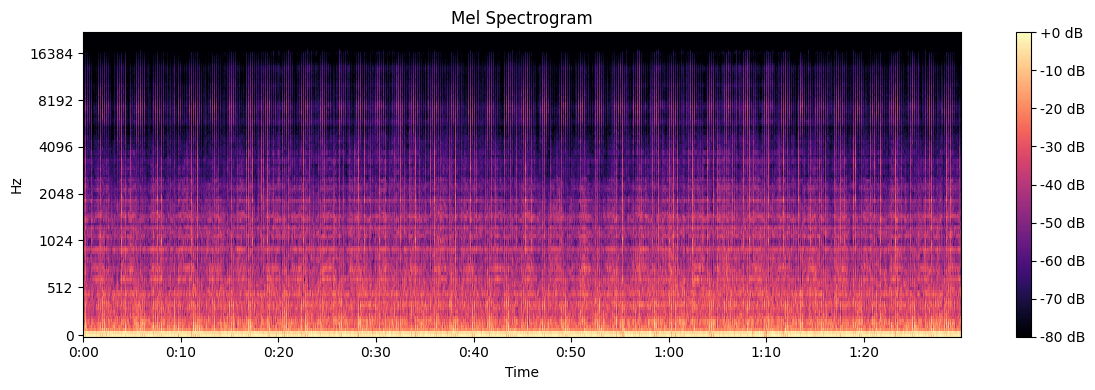

In [19]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Load your audio
y, sr = librosa.load("remix_output_prompt_1024_steps.wav", sr=None)

# Generate log-power Mel spectrogram
S = librosa.feature.melspectrogram(y=y, sr=44100, n_fft=2048, hop_length=512, n_mels=128)
log_S = librosa.power_to_db(S, ref=np.max)

# Plot
plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title("Mel Spectrogram")
plt.tight_layout()
plt.show()
